In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
import cv2
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.learner import cnn_config
from fastai.vision.models.unet import _get_sfs_idxs

from torchvision.models import vgg16_bn

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)
src = ImageImageList.from_folder(path, recurse=True).random_split_by_pct(0.1, seed=42)

In [5]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: x)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [6]:
data = get_data(64,64)

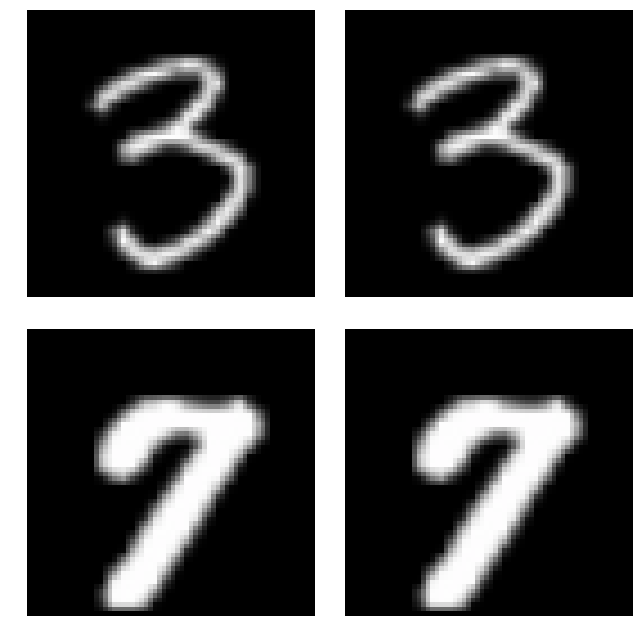

In [14]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

### Loss

In [7]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [8]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [9]:
gram_matrix(t)

tensor([[[0.0207, 0.0207, 0.0207],
         [0.0207, 0.0207, 0.0207],
         [0.0207, 0.0207, 0.0207]],

        [[0.0207, 0.0207, 0.0207],
         [0.0207, 0.0207, 0.0207],
         [0.0207, 0.0207, 0.0207]]])

In [10]:
base_loss = F.l1_loss

In [11]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [12]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [13]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [14]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

### Autoencoder

In [15]:
class DecoderBlock(nn.Module):
    
    def __init__(self, up_in_c:int, x_in_c:int, bilinear:bool=False, leaky:float=None,
                 self_attention:bool=False, **kwargs):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(up_in_c, x_in_c, 2, stride=2)

        self.conv1 = conv_layer(x_in_c, x_in_c, leaky=leaky, **kwargs)
        self.conv2 = conv_layer(x_in_c, x_in_c, leaky=leaky, self_attention=self_attention, **kwargs)
        self.relu = relu(leaky=leaky)

    def forward(self, up_in:Tensor) -> Tensor:
        up_out = self.up(up_in)

        x = self.relu(up_out)
        return self.conv2(self.conv1(x))

In [16]:
class BottleNeck(nn.Module):

    def __init__(self, ni: int, middle_nf: int=32, **kwargs):
        super().__init__()

        self.middle_in = conv_layer(ni, middle_nf, **kwargs)
        self.bn = batchnorm_2d(ni)
        self.relu = nn.ReLU()

    def forward(self, x):

        x = self.relu(self.bn(x))
        return self.middle_in(x)
    
class Decoder(nn.Module):

    def __init__(self, steps: int, middle_nf: int=32, middle_nf_out: int=512, channels_out: int=3, **kwargs):
        super().__init__()

        self.middle_out = conv_layer(middle_nf, middle_nf_out, **kwargs)

        self.up_path = []
        up_in_c = middle_nf_out
        for step in range(steps):
            x_in_c = up_in_c // 2

            decoder_block = DecoderBlock(up_in_c, x_in_c, **kwargs).eval()
            self.up_path.append(decoder_block)

            up_in_c = x_in_c


        self.up_path = nn.Sequential(*self.up_path)
        self.final = conv_layer(x_in_c, channels_out, ks=1, use_activ=False, **kwargs)

    def forward(self, x):

        x = self.middle_out(x)
        x = self.up_path(x)
        return self.final(x)

In [17]:
class AutoEncoder(nn.Module):
    def __init__(self, arch=models.resnet18, channels_out: int=3, middle_nf: int=32):
        super().__init__()
        self.feature_extractor = create_body(arch)

        imsize = (256,256)
        sfs_szs = model_sizes(self.feature_extractor, size=imsize)
        x = dummy_eval(self.feature_extractor, imsize).detach()

        x1, steps = x.shape[-1], 0
        while x1 < imsize[0]:
            x1 *= 2
            steps += 1

        ni = sfs_szs[-1][1]
        self.bottle_neck = BottleNeck(ni, middle_nf)
        self.decoder = Decoder(steps, middle_nf, ni, channels_out)

    def forward(self, im):

        x = self.feature_extractor(im)
        x = self.bottle_neck(x)
        x = self.decoder(x)

        return x

In [18]:
data = get_data(64, 64)
arch = models.resnet18

In [29]:
middle_nf = 8

meta = cnn_config(arch)
body = create_body(arch)
model = to_device(AutoEncoder(arch, channels_out=data.c, middle_nf=middle_nf), data.device)
learn = Learner(data, model, loss_func=feat_loss, callback_fns=[ShowGraph, LossMetrics])
learn.split([learn.model.feature_extractor, learn.model.bottle_neck, learn.model.decoder])
learn.freeze_to(-2)

apply_init(model.bottle_neck, nn.init.kaiming_normal_)
apply_init(model.decoder, nn.init.kaiming_normal_)

In [28]:
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


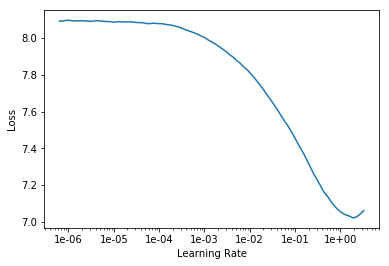

In [20]:
learn.lr_find()
learn.recorder.plot()

In [82]:
learn.summary()

'======================================================================\nLayer (type)         Output Shape         Param #    Trainable \n======================================================================\nConv2d               [64, 64, 64, 64]     9408       False     \n______________________________________________________________________\nBatchNorm2d          [64, 64, 64, 64]     128        True      \n______________________________________________________________________\nReLU                 [64, 64, 64, 64]     0          False     \n______________________________________________________________________\nMaxPool2d            [64, 64, 32, 32]     0          False     \n______________________________________________________________________\nConv2d               [64, 64, 32, 32]     36864      False     \n______________________________________________________________________\nBatchNorm2d          [64, 64, 32, 32]     128        True      \n________________________________________

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,4.952888,3.876828,0.696681,0.301209,0.338830,0.073009,0.851704,1.535192,0.080202
2,4.228995,4.581532,1.114063,0.245862,0.380760,0.082436,0.872445,1.800444,0.085522
3,3.843546,4.054857,0.756578,0.227669,0.313767,0.083795,0.782395,1.781973,0.108681
4,3.569070,4.708220,1.169325,0.238240,0.312228,0.068796,0.983016,1.854463,0.082152
5,3.326361,3.943839,0.562374,0.198041,0.284618,0.075657,0.762813,1.959077,0.101259
6,3.044867,4.082463,0.621803,0.197991,0.285459,0.074086,0.872839,1.939828,0.090457
7,2.769871,3.328485,0.531610,0.174533,0.245365,0.063841,0.695939,1.535774,0.081423
8,2.583824,2.746388,0.375449,0.153867,0.212520,0.050063,0.619365,1.272944,0.062179
9,2.440091,2.238766,0.300685,0.134608,0.184316,0.045363,0.515374,1.000577,0.057842
10,2.383632,1.620121,0.160107,0.103178,0.157901,0.042597,0.336379,0.764272,0.055688


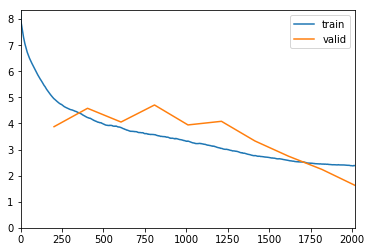

In [30]:
learn.fit_one_cycle(10, 1e-1)

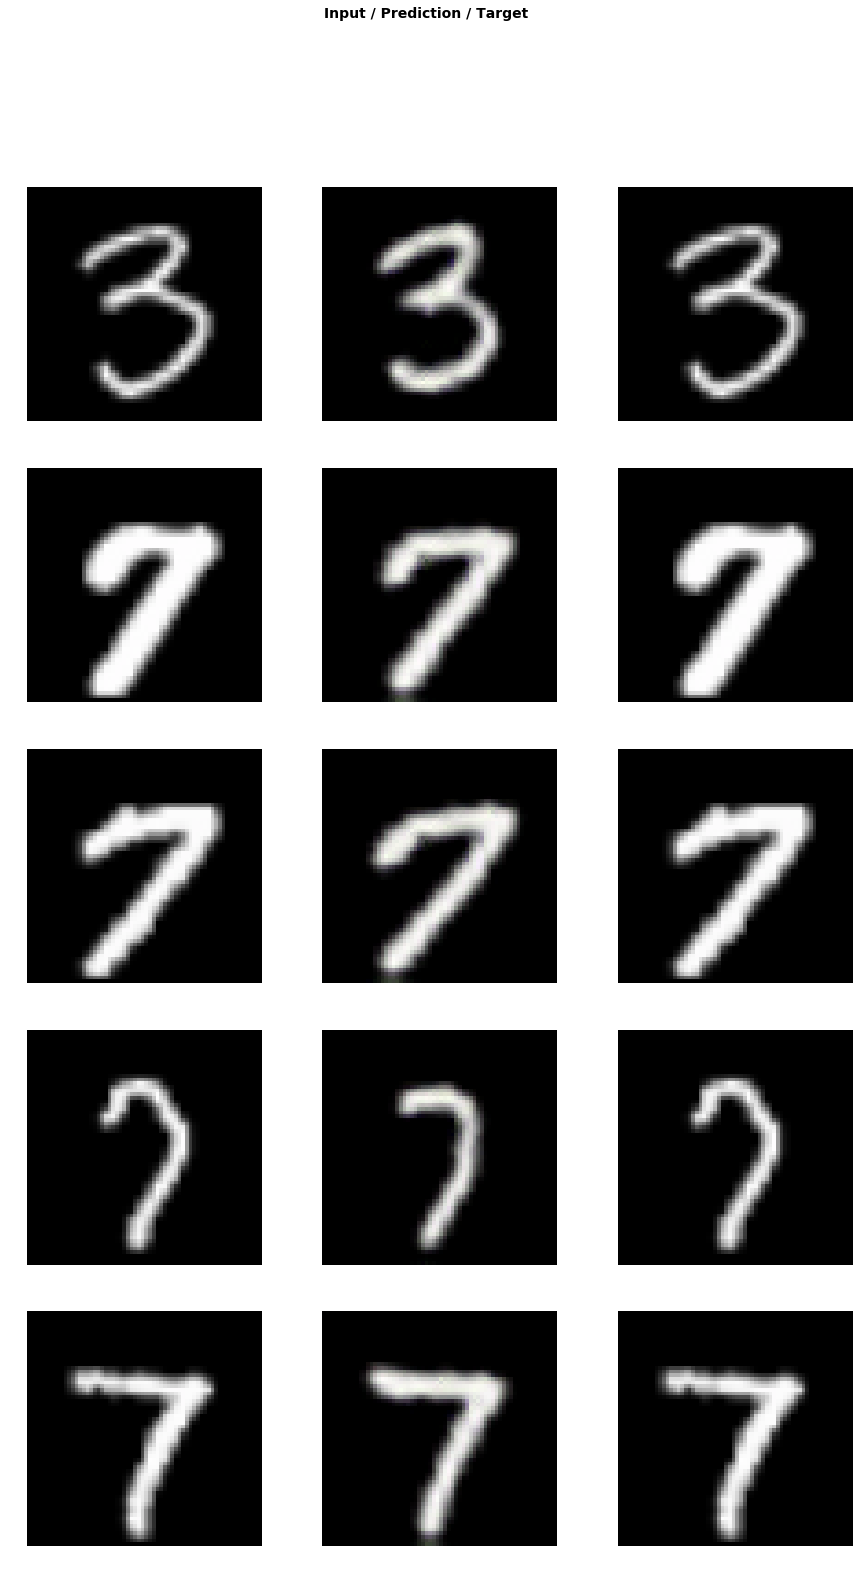

In [23]:
learn.show_results(rows=5, imgsize=5)

### Save features

In [31]:
learn.model = nn.Sequential(*[learn.model.feature_extractor, learn.model.bottle_neck])
result = learn.get_preds(ds_type=DatasetType.Valid)

hem_regex = re.compile(r'UID_(H[0-9]+)_', re.IGNORECASE)
all_regex = re.compile(r'UID_([0-9]+)_', re.IGNORECASE)

import pickle
output = {}
for fn, y in zip(learn.data.valid_dl.items, to_np(result[0])):
    item = {'Path': fn, 'features': y, 'Class': fn.parent.name}
    item['Patient'] = fn.parent.name
    output[fn.name] = item

with open('data_mnist_{}f.pkl'.format(middle_nf), 'wb') as outfile:
    pickle.dump(output, outfile)